# Introduction

I have deided to work with the Titanic dataset again. this kernel is focusing on comparing the performance of several machine learning algorithms. I use several clasification model to create a model predicting survival on the Titanic. 
I am hoping to learn a lot from this site, so feedback is very welcome! This kernel is always improving because of your feedback!!!

There are three parts to my script as follows:

1. Load the library and data
2. Data cleaning
3. Data spliting
4. Training,testing, and Peformance comparison
5. Tuning the algorithm

If you like this work and want to see my other works, you can check it here:

https://www.kaggle.com/aldemuro


# 1. Load the library and data

In this section the library and the data used are loaded into the sytem

## 1.1 Load the library

In [3]:
#sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve
from sklearn import ensemble, linear_model, neighbors, svm, tree, neural_network
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm,model_selection, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

#load package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from math import sqrt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## 1.2 Load the data

In [7]:
## Read in file
# train_original = pd.read_csv('../input/train.csv')
# test_original = pd.read_csv('../input/test.csv')
# train_original.sample(10)
# total = [train_original,test_original]
total = pd.read_csv('./gender_submission.csv')


# 2. Data Cleaning
## 2.1 Retrive the salutation and Eliminating unused variable

'Salutation' variable can be retrieved from 'Name' column by taking the string between space string and '.' string.

In [8]:
#Retrive the salutation from 'Name' column
for dataset in total:
    dataset['Salutation'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)    

AttributeError: 'str' object has no attribute 'Name'

In [4]:
pd.crosstab(train_original['Salutation'], train_original['Sex'])

Sex,female,male
Salutation,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [5]:
pd.crosstab(test_original['Salutation'], test_original['Sex'])

Sex,female,male
Salutation,,
Col,0,2
Dona,1,0
Dr,0,1
Master,0,21
Miss,78,0
Mr,0,240
Mrs,72,0
Ms,1,0
Rev,0,2


 afterward, 'Salutation' column should be factorized to be fit in our future model

In [6]:
for dataset in total:
    dataset['Salutation'] = dataset['Salutation'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Salutation'] = dataset['Salutation'].replace('Mlle', 'Miss')
    dataset['Salutation'] = dataset['Salutation'].replace('Ms', 'Miss')
    dataset['Salutation'] = dataset['Salutation'].replace('Mme', 'Mrs')
    dataset['Salutation'] = pd.factorize(dataset['Salutation'])[0]
    


#total.Salutation = pd.factorize(total.Salutation)[0]   


In [7]:
pd.crosstab(train_original['Salutation'], train_original['Sex'])

Sex,female,male
Salutation,,
0,0,517
1,126,0
2,185,0
3,0,40
4,3,20


In [8]:
pd.crosstab(test_original['Salutation'], test_original['Sex'])

Sex,female,male
Salutation,,
0,0,240
1,72,0
2,79,0
3,0,21
4,1,5


The next step is deletin column that will not be used in our models.

In [9]:
#clean unused variable
train=train_original.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
test=test_original.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
total = [train,test]

train.shape, test.shape

((891, 9), (418, 8))

## 2.2 Detect and fill the missing data

In [10]:
#Detect the missing data in 'train' dataset
train.isnull().sum()

Survived        0
Pclass          0
Sex             0
Age           177
SibSp           0
Parch           0
Fare            0
Embarked        2
Salutation      0
dtype: int64

As it is shown above, there are 2 columns which have missing data. the way I'm handling missing 'Age' column is by filling them by the median of age in every passenger class. there are only two data missing in 'Embarked' column. Considering Sex=female and Fare=80, Ports of Embarkation (Embarked) for two missing cases can be assumed to be Cherbourg (C).

In [11]:
## Create function to replace missing data with the median value
def fill_missing_age(dataset):
    for i in range(1,4):
        median_age=dataset[dataset["Salutation"]==i]["Age"].median()
        dataset["Age"]=dataset["Age"].fillna(median_age)
        return dataset

train = fill_missing_age(train)

In [12]:
## Embarked missing cases 
train[train['Embarked'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Salutation
61,1,1,female,38.0,0,0,80.0,NaN,2
829,1,1,female,62.0,0,0,80.0,NaN,1


In [13]:
train["Embarked"] = train["Embarked"].fillna('C')

Detecting the missing data in 'test' dataset is done to get the insight which column consist missing data. as it is shown below, there are 2 column which have missing value. they are 'Age' and 'Fare' column. The same function is used in order to filled the missing 'Age' value. missing 'Fare' value is filled by finding the median of 'Fare' value in the 'Pclass' = 3 and 'Embarked' = S.

In [14]:
test.isnull().sum()

Pclass         0
Sex            0
Age           86
SibSp          0
Parch          0
Fare           1
Embarked       0
Salutation     0
dtype: int64

In [15]:
test[test['Age'].isnull()].head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Salutation
10,3,male,NaN,0,0,7.8958,S,0
22,1,female,NaN,0,0,31.6833,S,1
29,3,male,NaN,2,0,21.6792,C,0
33,3,female,NaN,1,2,23.4500,S,1
36,3,female,NaN,0,0,8.0500,S,2


In [16]:
#apply the missing age method to test dataset
test = fill_missing_age(test)

In [17]:
test[test['Fare'].isnull()]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Salutation
152,3,male,60.5,0,0,NaN,S,0


In [18]:
#filling the missing 'Fare' data with the  median
def fill_missing_fare(dataset):
    median_fare=dataset[(dataset["Pclass"]==3) & (dataset["Embarked"]=="S")]["Fare"].median()
    dataset["Fare"]=dataset["Fare"].fillna(median_fare)
    return dataset

test = fill_missing_fare(test)

## 2.3 Re-Check for missing data

In [19]:
## Re-Check for missing data
train.isnull().any()

Survived      False
Pclass        False
Sex           False
Age           False
SibSp         False
Parch         False
Fare          False
Embarked      False
Salutation    False
dtype: bool

In [20]:
## Re-Check for missing data
test.isnull().any()

Pclass        False
Sex           False
Age           False
SibSp         False
Parch         False
Fare          False
Embarked      False
Salutation    False
dtype: bool

discretize Age feature

In [21]:

for dataset in total:
    dataset.loc[dataset["Age"] <= 9, "Age"] = 0
    dataset.loc[(dataset["Age"] > 9) & (dataset["Age"] <= 19), "Age"] = 1
    dataset.loc[(dataset["Age"] > 19) & (dataset["Age"] <= 29), "Age"] = 2
    dataset.loc[(dataset["Age"] > 29) & (dataset["Age"] <= 39), "Age"] = 3
    dataset.loc[(dataset["Age"] > 29) & (dataset["Age"] <= 39), "Age"] = 3
    dataset.loc[dataset["Age"] > 39, "Age"] = 4


Discretize Fare

In [22]:
pd.qcut(train["Fare"], 8).value_counts()

(-0.001, 7.75]       140
(9.841, 14.454]      113
(69.488, 512.329]    112
(24.479, 31.0]       112
(7.91, 9.841]        111
(31.0, 69.488]       110
(14.454, 24.479]     110
(7.75, 7.91]          83
Name: Fare, dtype: int64

In [23]:
for dataset in total:
    dataset.loc[dataset["Fare"] <= 7.75, "Fare"] = 0
    dataset.loc[(dataset["Fare"] > 7.75) & (dataset["Fare"] <= 7.91), "Fare"] = 1
    dataset.loc[(dataset["Fare"] > 7.91) & (dataset["Fare"] <= 9.841), "Fare"] = 2
    dataset.loc[(dataset["Fare"] > 9.841) & (dataset["Fare"] <= 14.454), "Fare"] = 3   
    dataset.loc[(dataset["Fare"] > 14.454) & (dataset["Fare"] <= 24.479), "Fare"] = 4
    dataset.loc[(dataset["Fare"] >24.479) & (dataset["Fare"] <= 31), "Fare"] = 5   
    dataset.loc[(dataset["Fare"] > 31) & (dataset["Fare"] <= 69.487), "Fare"] = 6
    dataset.loc[dataset["Fare"] > 69.487, "Fare"] = 7

Factorized 2 of the column whic are 'Sex' and 'Embarked'

In [24]:
for dataset in total:
    dataset['Sex'] = pd.factorize(dataset['Sex'])[0]
    dataset['Embarked']= pd.factorize(dataset['Embarked'])[0]
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Salutation
0,0,3,0,2.0,1,0,0.0,0,0
1,1,1,1,3.0,1,0,7.0,1,1
2,1,3,1,2.0,0,0,2.0,0,2
3,1,1,1,3.0,1,0,6.0,0,1
4,0,3,0,3.0,0,0,2.0,0,0


Checking the correlation between features

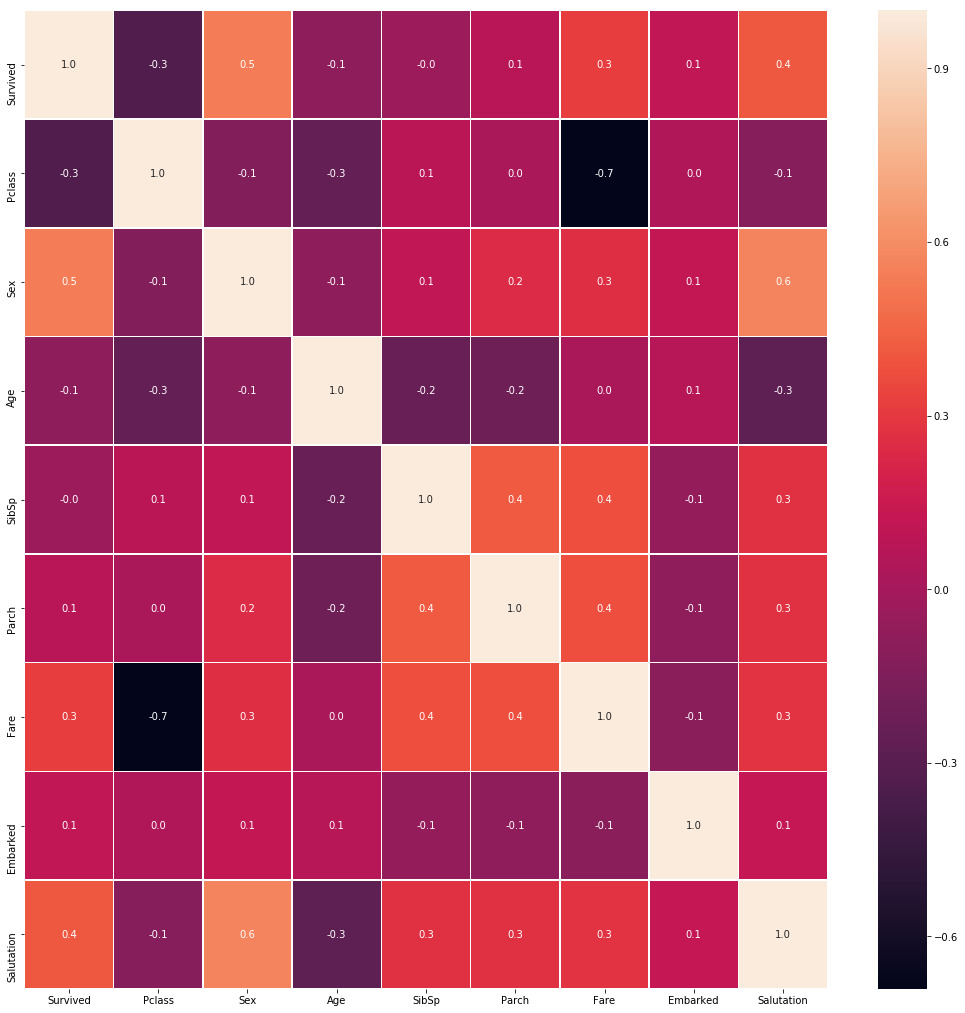

In [25]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

# 3. Spliting the data

Seperate input features from target feature

In [26]:
x = train.drop("Survived", axis=1)
y = train["Survived"]

Split the data into training and validation sets

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.25,random_state=1)

# 4. Performance Comparison

List of Machine Learning Algorithm (MLA) used

In [28]:

MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model. RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
   #tree.ExtraTreeClassifier(),
    
    ]


Train the data into the model and calculate the performance

In [29]:
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)


row_index = 0
for alg in MLA:
    
    
    predicted = alg.fit(x_train, y_train).predict(x_test)
    fp, tp, th = roc_curve(y_test, predicted)
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index,'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Train Accuracy'] = round(alg.score(x_train, y_train), 4)
    MLA_compare.loc[row_index, 'MLA Test Accuracy'] = round(alg.score(x_test, y_test), 4)
    MLA_compare.loc[row_index, 'MLA Precission'] = precision_score(y_test, predicted)
    MLA_compare.loc[row_index, 'MLA Recall'] = recall_score(y_test, predicted)
    MLA_compare.loc[row_index, 'MLA AUC'] = auc(fp, tp)





    row_index+=1
    
MLA_compare.sort_values(by = ['MLA Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

,MLA Name,MLA Train Accuracy,MLA Test Accuracy,MLA Precission,MLA Recall,MLA AUC
6,LogisticRegressionCV,0.8069,0.7982,0.812500,0.684211,0.783512
0,AdaBoostClassifier,0.8383,0.7937,0.818182,0.663158,0.776891
16,LinearSVC,0.8054,0.7937,0.802469,0.684211,0.779605
8,RidgeClassifierCV,0.8039,0.7892,0.785714,0.694737,0.777056
2,ExtraTreesClassifier,0.9162,0.7892,0.824324,0.642105,0.770271
1,BaggingClassifier,0.9102,0.7892,0.833333,0.631579,0.768914
12,GaussianNB,0.8129,0.7803,0.761364,0.705263,0.770600
17,DecisionTreeClassifier,0.9162,0.7803,0.819444,0.621053,0.759745
5,GaussianProcessClassifier,0.8877,0.7758,0.835821,0.589474,0.751768
3,GradientBoostingClassifier,0.8743,0.7758,0.816901,0.610526,0.754482


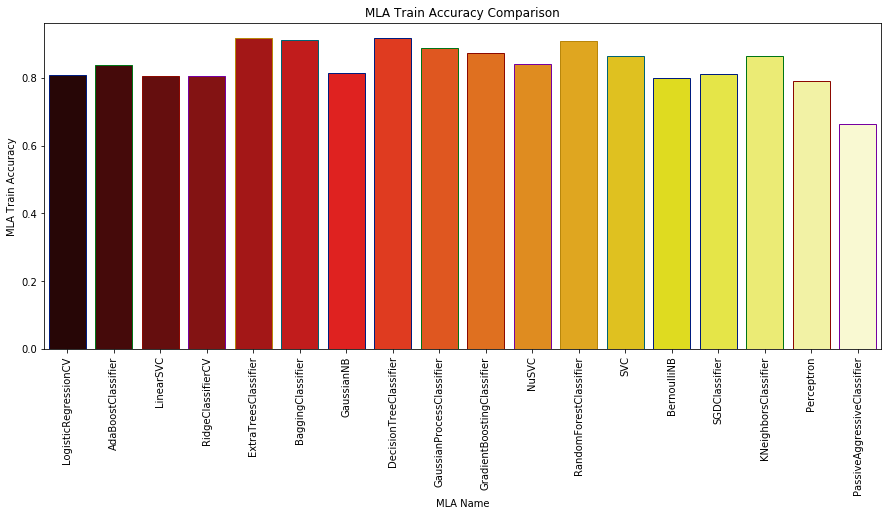

In [30]:
plt.subplots(figsize=(15,6))
sns.barplot(x="MLA Name", y="MLA Train Accuracy",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('MLA Train Accuracy Comparison')
plt.show()

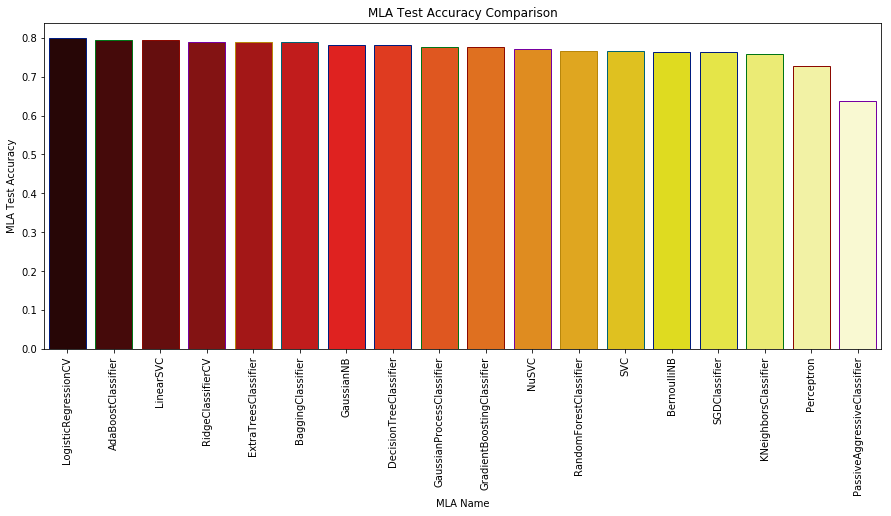

In [31]:
plt.subplots(figsize=(15,6))
sns.barplot(x="MLA Name", y="MLA Test Accuracy",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('MLA Test Accuracy Comparison')
plt.show()

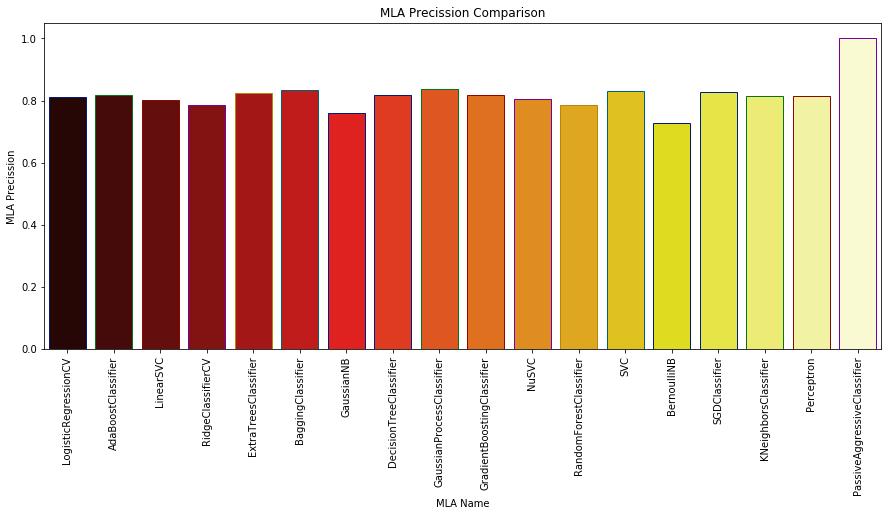

In [32]:
plt.subplots(figsize=(15,6))
sns.barplot(x="MLA Name", y="MLA Precission",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('MLA Precission Comparison')
plt.show()

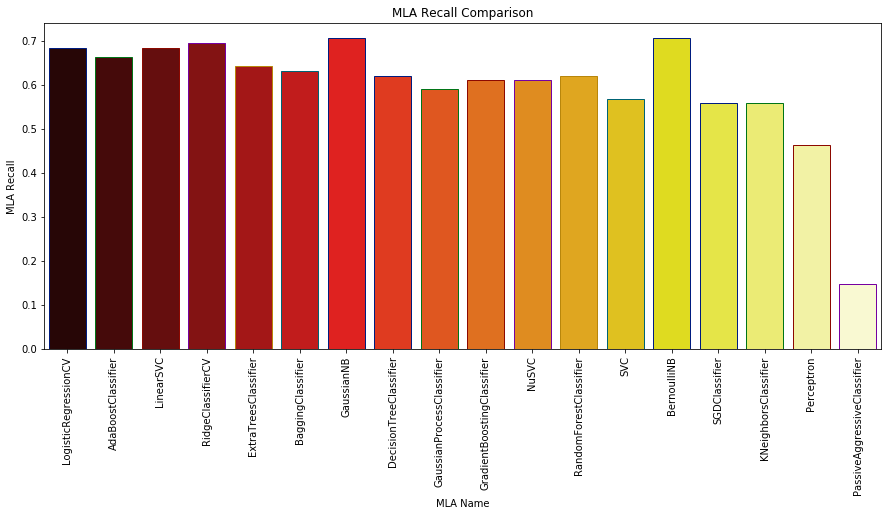

In [33]:
plt.subplots(figsize=(15,6))
sns.barplot(x="MLA Name", y="MLA Recall",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('MLA Recall Comparison')
plt.show()

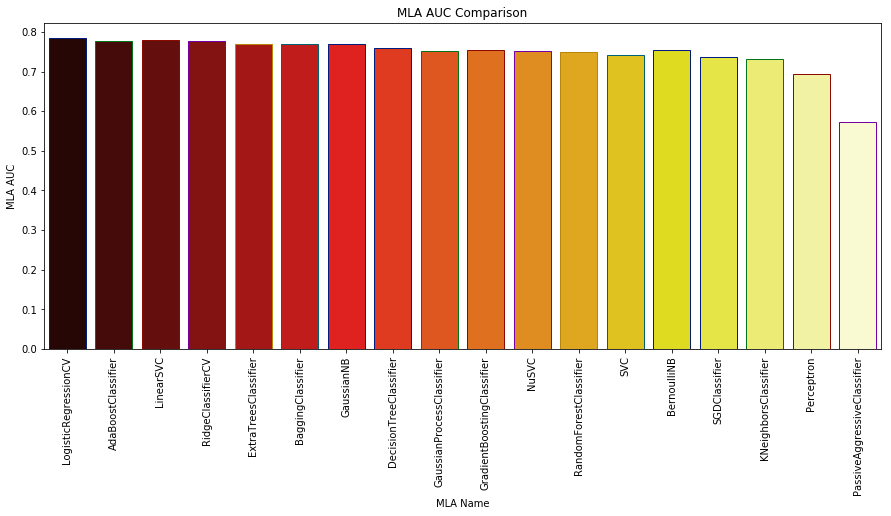

In [34]:
plt.subplots(figsize=(15,6))
sns.barplot(x="MLA Name", y="MLA AUC",data=MLA_compare,palette='hot',edgecolor=sns.color_palette('dark',7))
plt.xticks(rotation=90)
plt.title('MLA AUC Comparison')
plt.show()

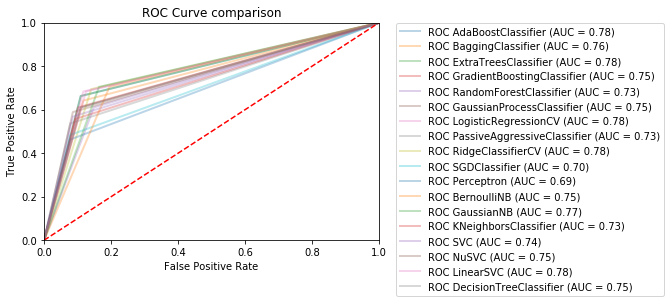

In [35]:
index = 1
for alg in MLA:
    
    
    predicted = alg.fit(x_train, y_train).predict(x_test)
    fp, tp, th = roc_curve(y_test, predicted)
    roc_auc_mla = auc(fp, tp)
    MLA_name = alg.__class__.__name__
    plt.plot(fp, tp, lw=2, alpha=0.3, label='ROC %s (AUC = %0.2f)'  % (MLA_name, roc_auc_mla))
   
    index+=1

plt.title('ROC Curve comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')    
plt.show()

# 4. Tuning the algorithm

In [36]:
tunealg = ensemble.ExtraTreesClassifier() #Select the algorithm to be tuned
tunealg.fit(x_train, y_train)

print('BEFORE tuning Parameters: ', tunealg.get_params())
print("BEFORE tuning Training w/bin set score: {:.2f}". format(tunealg.score(x_train, y_train))) 
print("BEFORE tuning Test w/bin set score: {:.2f}". format(tunealg.score(x_test, y_test)))
print('-'*10)



BEFORE tuning Parameters:  {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
BEFORE tuning Training w/bin set score: 0.92
BEFORE tuning Test w/bin set score: 0.78
----------


In [37]:
#tune parameters
param_grid = {#'bootstrap': [True, False],
              'class_weight': ['balanced' , None],
              #'max_depth': [1, 2,3,4, None],
              #'max_features': ['log2', 'auto'],
              #'max_leaf_nodes': [0,1,2,3,4, None],
              #'min_impurity_decrease': [True, False, None],
              #'min_impurity_split': [True, False],
              #'min_samples_leaf': [1, 2,3,4,5],
              #'min_samples_split': [1,2,3,4,5],
              #'min_weight_fraction_leaf': [0.0,1.0,2.0,3.0,4.0,5.0], 
              #'n_estimators': [10,15,25,35,45], 
              'n_jobs':  [1,2,3,4,5], 
              #'oob_score': [True, False], 
              'random_state': [0,1, 2,3,4, None], 
              #'verbose': [0,1, 2,3,4, 5], 
              'warm_start': [True, False]
             }
# So, what this GridSearchCV function do is finding the best combination of parameters value that is set above.
tune_model = model_selection.GridSearchCV(linear_model.PassiveAggressiveClassifier(), param_grid=param_grid, scoring = 'roc_auc')
tune_model.fit (x_train, y_train)

print('AFTER tuning Parameters: ', tune_model.best_params_)
print("AFTER tuning Training w/bin set score: {:.2f}". format(tune_model.score(x_train, y_train))) 
print("AFTER tuning Test w/bin set score: {:.2f}". format(tune_model.score(x_test, y_test)))
print('-'*10)

AFTER tuning Parameters:  {'class_weight': 'balanced', 'n_jobs': 2, 'random_state': None, 'warm_start': True}
AFTER tuning Training w/bin set score: 0.86
AFTER tuning Test w/bin set score: 0.82
----------
